In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import os
import torch
import sys
from DDM.utls.scaled_sigmoid import scaled_sigmoid
from DDM.utls.utl_wfpt import utl_wfpt
from scipy.stats import spearmanr
import scipy.stats as stats



project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add it to sys.path
sys.path.append(project_root)
module_path = os.path.join(project_root, "src")  # Adjust "src" based on actual location
sys.path.append(module_path)
import gdbn_model


In [89]:
from PIL import Image
import numpy as np
import os

# Carica tutte le immagini in un dizionario
cartella = '/home/student/Desktop/Groundeep/conferenza_DBNRT/Dot_comparison_task/Dot Comparison Task/Task Completo'
dim_target = (100, 100)

immagini_dict = {}

for nome_file in os.listdir(cartella):
    if nome_file.endswith('.jpg'):
        path = os.path.join(cartella, nome_file)

        img = Image.open(path).convert('L')
        img = img.resize(dim_target, resample=Image.NEAREST)
        img = np.array(img)
        img = (img >= 128).astype(np.uint8)
        img = img.reshape(-1)

        immagini_dict[nome_file] = img

data = pd.read_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/Human_seq_40.xlsx")
mask = data['Subject'] == 5
trial_list1 = data[mask]['FirstStim'].values
trial_list2 = data[mask]['SecondStim'].values
num_1 = data[mask]['n1'].values
num_2 = data[mask]['n2'].values

# to be used later for model comparison
subjects = data['Subject'].unique()

immagini_N1 = [immagini_dict[nome] for nome in trial_list1]
immagini_N2 = [immagini_dict[nome] for nome in trial_list2]

batch_N1 = np.stack(immagini_N1)
batch_N2 = np.stack(immagini_N2)


groundtruth_binary = np.array(num_1 > num_2).astype(int) #1 if numerosit in first image is greater


In [90]:
from scipy.optimize import minimize
import numpy as np

def fit_ddm_with_signal(rt, resp, s, x0=(1.0, 1.0, 1.5, 0.5, 0.2), bounds=None):
    """
    Fit DDM con drift v = beta * s + bias (bias intercetta sul drift).
    Restituisce parametri e log-likelihood massima.

    Parametri ottimizzati:
      beta : scala del segnale
      bias : intercetta (offset) del drift
      a    : distanza tra soglie
      w    : centro della distribuzione iniziale
      Ter  : tempo di non-decisione
    """
    if bounds is None:
        bounds = [
            (0.01, 10),   # beta
            (-5.0, 5.0),  # bias
            (0.5, 3),     # a
            (0.01, 0.99), # w
            (0.05, 0.5)   # Ter
        ]
    EPS = 1e-10

    def neg_ll(params):
        beta, bias, a, w, Ter = params
        v = beta * s + bias
        logp_sum = 0.0
        for t, r, vv in zip(rt, resp, v):
            t_eff = t - Ter
            if t_eff <= 0:
                logp_sum += np.log(EPS)
                continue
            if r == 1:
                p = utl_wfpt(t_eff, vv, a, w)
            else:
                p = utl_wfpt(t_eff, -vv, a, 1 - w)
            logp_sum += np.log(max(p, EPS))
        return -logp_sum

    res = minimize(neg_ll, x0=x0, bounds=bounds, method="L-BFGS-B")
    best = dict(beta=res.x[0], bias=res.x[1], a=res.x[2], w_center=res.x[3], Ter=res.x[4])
    return best, -res.fun


## Extract data 


In [91]:
cartella = '/home/student/Desktop/Groundeep/conferenza_DBNRT/Dot_comparison_task/Dot Comparison Task/Task Completo'
dim_target = (100, 100)

immagini_dict = {}

for nome_file in os.listdir(cartella):
    if nome_file.endswith('.jpg'):
        path = os.path.join(cartella, nome_file)

        img = Image.open(path).convert('L')
        img = img.resize(dim_target, resample=Image.NEAREST)
        img = np.array(img)
        img = (img >= 128).astype(np.uint8)
        img = img.reshape(-1)

        immagini_dict[nome_file] = img

data = pd.read_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/Human_seq_40.xlsx")
mask = data['Subject'] == 5
trial_list1 = data[mask]['FirstStim'].values
trial_list2 = data[mask]['SecondStim'].values
num_1 = data[mask]['n1'].values
num_2 = data[mask]['n2'].values

immagini_N1 = [immagini_dict[nome] for nome in trial_list1]
immagini_N2 = [immagini_dict[nome] for nome in trial_list2]

batch_N1 = np.stack(immagini_N1)
batch_N2 = np.stack(immagini_N2)



human_rt = (data[mask]['StimTestb.RT'].values)/1000
human_resp = data[mask]['StimTestb.RESP'].values
groundtruth_resp = data[mask]['StimTestb.CRESP'].values
subjects = data['Subject'].unique()



# Mask per rimuovere NaN in tutte le variabili
valid_mask = (
    ~np.isnan(human_rt) &
    ~pd.isna(human_resp) &
    ~pd.isna(groundtruth_resp) 
)

# Applica filtro
human_rt = human_rt[valid_mask]
human_resp = human_resp[valid_mask]
groundtruth_resp = groundtruth_resp[valid_mask] # subject response
num_1 = num_1[valid_mask] # numerosity first stimulus
num_2 = num_2[valid_mask] # numerosity second stimulus
batch_N1 = batch_N1[valid_mask] 
batch_N2 = batch_N2[valid_mask]

resp_binary = np.where(human_resp == '{LEFTARROW}', 0,
          np.where(human_resp == '{RIGHTARROW}', 1, np.nan)).astype(float)
groundtruth_binary = np.where(groundtruth_resp == '{LEFTARROW}', 0,
          np.where(groundtruth_resp == '{RIGHTARROW}', 1, np.nan)).astype(float)

## Fitting del modello


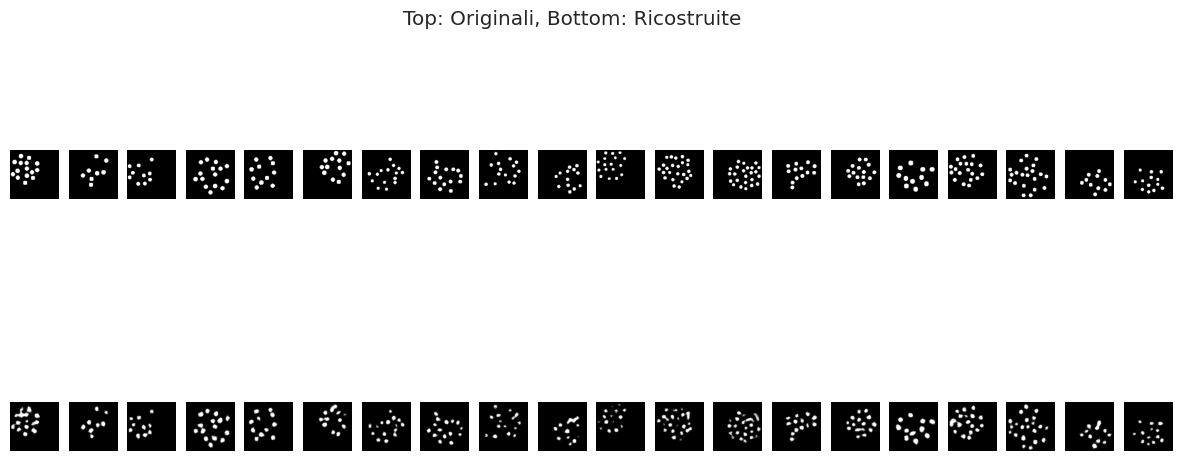

In [92]:
import torch
import matplotlib.pyplot as plt

def plot_reconstructions(dbn, batch_N1, n_images=20):
    """
    dbn: il tuo modello DBN
    batch_N1: tensore [batch_size, ...] di immagini
    n_images: numero di immagini da plottare
    """

    batch_N1_device = ((torch.tensor(batch_N1,dtype = torch.float32))).to(dbn.device)
    
    with torch.no_grad():
        # Forward pass
        h1_probs = dbn.layers[0].forward(batch_N1_device)
        h2_probs = dbn.layers[1].forward(h1_probs)
        
        # Backward pass (ricostruzione)
        h1_recon = dbn.layers[1].backward(h2_probs)
        batch_recon = dbn.layers[0].backward(h1_recon)
        
    # Porta i dati su CPU e numpy
    originals = batch_N1_device.cpu().numpy()
    reconstructions = batch_recon.cpu().numpy()
    
    # Plot
    plt.figure(figsize=(15, 6))  # larghezza maggiore
    for i in range(n_images):
        # Immagine originale
        plt.subplot(2, n_images, i + 1)
        plt.imshow(originals[i].reshape(100,100), cmap='gray')  # modifica la reshape se le immagini hanno dimensioni diverse
        plt.axis('off')
        
        # Immagine ricostruita
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructions[i].reshape(100,100), cmap='gray')
        plt.axis('off')
    
    plt.suptitle("Top: Originali, Bottom: Ricostruite")
    plt.show()

# Esempio di utilizzo:
model_path = "/home/student/Desktop/Groundeep/networks/uniform/idbn_binary_v3/idbn_new_dataset_idbn_trained_uniform_1000_2000.pkl"
model_path 
with open(model_path, 'rb') as f:
    dbn = pkl.load(f)
plot_reconstructions(dbn, batch_N1, n_images=20)


## Extracting Embeddings


In [93]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle as pkl

def compute_subject_dbn_activations(
    dbn_folder,
    batch_N1,
    batch_N2,
    num_1,
    num_2,
    fine_tune=True,
    train_epochs=50,
    lr=1e-2,
    device_fallback='cpu',
    verbose=True,
    return_probs=False,
    softmax_for_probs=False
):
    """
    Per ogni DBN nella cartella dbn_folder:
      - calcola embedding per batch_N1 e batch_N2 usando dbn.layers
      - concatena (emb_N1, emb_N2) lungo la feature-dim -> XComp (N, F)
      - costruisce target y (scalari): 0 se n1>n2, 1 se n2>n1 (tie -> 0 o 1 arbitrario)
      - allena (opzionale) un classificatore lineare con CrossEntropyLoss (target scalare)
      - restituisce dizionario activations_dict[arch] = logits (N,2) (raw, prima di softmax)
    
    Argomenti:
      - batch_N1, batch_N2: array-like shape (N, feat) o torch tensors
      - num_1, num_2: array-like con lunghezza N (numerosità)
      - fine_tune: se True esegue un piccolo fine-tuning del linear classifier su XComp
      - train_epochs, lr: iperparametri per il training
      - device_fallback: device da usare se dbn.device non è definito
      - return_probs: se True ritorna anche probabilità (softmax o sigmoid)
      - softmax_for_probs: se True usa softmax per probs (consigliato), altrimenti sigmoid
    """
    # convert batch inputs to tensors (leave on cpu for now)
    if not isinstance(batch_N1, torch.Tensor):
        batch_N1 = torch.tensor(np.stack(batch_N1), dtype=torch.float32)
    if not isinstance(batch_N2, torch.Tensor):
        batch_N2 = torch.tensor(np.stack(batch_N2), dtype=torch.float32)

    N = batch_N1.shape[0]
    # costruisci target scalare 0/1
    y_scalar = np.zeros(N, dtype=np.int64)
    for i, (a, b) in enumerate(zip(num_1, num_2)):
        if a > b:
            y_scalar[i] = 0
        elif b > a:
            y_scalar[i] = 1
        else:
            # tie: scegli arbitrariamente 0 (puoi cambiarlo)
            y_scalar[i] = 0

    y_tensor_ce = torch.tensor(y_scalar, dtype=torch.long)

    activations_dict = {}
    probs_dict = {} if return_probs else None

    for model_filename in os.listdir(dbn_folder):
        if not model_filename.endswith('.pkl'):
            continue
        arch = model_filename[:-4]
        model_path = os.path.join(dbn_folder, model_filename)
        if verbose:
            print(f"\nProcessing DBN: {arch}")

        try:
            with open(model_path, 'rb') as f:
                dbn = pkl.load(f)
        except Exception as e:
            print(f"  ERROR loading {arch}: {e}")
            continue

        # device handling: usa dbn.device se presente
        device = getattr(dbn, 'device', device_fallback)
        if isinstance(device, str):
            device = torch.device(device)
        batch_N1_d = batch_N1.to(device)
        batch_N2_d = batch_N2.to(device)

        # --- compute embeddings (assume dbn.layers[...] forward accept batch 2D) ---
        with torch.no_grad():
            # first-layer activation (probabilities) then second layer embedding (same style as your code)
            h1_N1 = dbn.layers[0].forward(batch_N1_d)
            emb_N1 = dbn.layers[1].forward(h1_N1)

            h1_N2 = dbn.layers[0].forward(batch_N2_d)
            emb_N2 = dbn.layers[1].forward(h1_N2)

        # ensure float on cpu for classifier training
        XComp = torch.cat((emb_N1, emb_N2), dim=1).cpu().float()  # shape (N, F)
        input_dim = XComp.shape[1]
        num_classes = 2

        # Build linear classifier
        classifier = nn.Linear(input_dim, num_classes, bias=True)
        classifier = classifier.cpu()  # train on CPU for stability (DBN on its device was used above)

        # optionally fine-tune the classifier on this subject's XComp
        if fine_tune:
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=0.0)
            classifier.train()
            for epoch in range(train_epochs):
                optimizer.zero_grad()
                outputs = classifier(XComp)       # logits shape (N,2)
                loss = criterion(outputs, y_tensor_ce)
                loss.backward()
                optimizer.step()
                # verbose minimal
                if verbose and (epoch == 0 or (epoch+1) % (max(1, train_epochs//5)) == 0):
                    print(f"    Epoch {epoch+1}/{train_epochs} - loss: {loss.item():.4f}")
        else:
            if verbose:
                print("    fine_tune disabled, using random-initialized linear classifier")

        # eval and produce logits (raw)
        classifier.eval()
        with torch.no_grad():
            logits = classifier(XComp).cpu().numpy()   # shape (N,2)

        # Diagnostic: check mapping orientation
        preds = np.argmax(logits, axis=1)
        acc_direct = (preds == y_scalar).mean()
        acc_flipped = ((1 - preds) == y_scalar).mean()  # if we flip columns
        if verbose:
            print(f"    Accuracy direct mapping: {acc_direct:.3f}, if flip columns: {acc_flipped:.3f}")
        #print("model_name{}_acc_{}".format(model_filename,acc_direct))
        # If flip mapping gives better alignment with y_true (i.e. classifier columns swapped),
        # swap columns of logits so column 0 always means "first stim > second stim"
        if acc_flipped > acc_direct + 1e-6:
            if verbose:
                print("    -> Detected inverted mapping: swapping logistic columns to align with y_true")
            logits = logits[:, ::-1]  # swap col 0/1

        # Save raw logits
        activations_dict[arch] = logits

        # optionally compute probabilities (softmax recommended)
        if return_probs:
            if softmax_for_probs:
                # numerically stable softmax
                m = np.max(logits, axis=1, keepdims=True)
                exp = np.exp(logits - m)
                probs = exp / exp.sum(axis=1, keepdims=True)
            else:
                # per-class sigmoid (less theoretically appropriate for exclusive classes)
                probs = 1.0 / (1.0 + np.exp(-logits))
            probs_dict[arch] = probs

    if return_probs:
        return activations_dict, probs_dict
    return activations_dict


# -----------------------------
# Esempio d'uso (schema)
# -----------------------------
# Assumendo che tu abbia già:
#   - dbn_folder (path)
#   - batch_N1, batch_N2: liste o array di immagini (N, feat)
#   - num_1, num_2: array lunghezza N
#
# activations_logits = compute_subject_dbn_activations(dbn_folder, batch_N1, batch_N2, num_1, num_2,
#                                                    fine_tune=True, train_epochs=50, lr=1e-2,
#                                                    verbose=True, return_probs=False)
#
# oppure per avere anche probabilità (softmax):
# activ_logits, activ_probs = compute_subject_dbn_activations(..., return_probs=True, softmax_for_probs=True)
#
# Nota: la funzione allena separatamente un linear classifier per ciascuna DBN
#       e controlla automaticamente se le colonne vanno invertite per allineare
#       "colonna 0 = primo stim > secondo stim".


## Runnning across subjects


In [94]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import zscore
def compute_signed_drift(signal, groundtruth_resp):
    # segno: +1 se corretta è RIGHT, -1 se corretta è LEFT
    labels_sign = np.where(groundtruth_resp == '{RIGHTARROW}', 1, -1)
    v = signal * labels_sign
    # opzionale: forza valori piccoli a non diventare 0
    v = np.sign(v) * np.maximum(np.abs(v), 1e-6)
    return v

def compare_models_with_params(filepath, immagini_dict, dbn_folder):
    # --- Carica dati ---
    data = pd.read_excel(filepath)
    subjects = data['Subject'].unique()
    all_results = []

    # Dizionario per salvare parametri di ogni soggetto
    params_by_model = {
        "log": [], "lin": [], "dbn_log": [], "dbn": [], "null": []
    }


    for subj in subjects:
        mask = data['Subject'] == subj
        trial_list1 = data[mask]['FirstStim'].values
        trial_list2 = data[mask]['SecondStim'].values
        num_1 = data[mask]['n1'].values
        num_2 = data[mask]['n2'].values

        # Ricostruisci immagini
        immagini_N1 = [immagini_dict[nome] for nome in trial_list1]
        immagini_N2 = [immagini_dict[nome] for nome in trial_list2]
        batch_N1 = np.stack(immagini_N1)
        batch_N2 = np.stack(immagini_N2)

        human_rt = data[mask]['StimTestb.RT'].values / 1000
        human_resp = data[mask]['StimTestb.RESP'].values
        groundtruth_resp = data[mask]['StimTestb.CRESP'].values

        valid_mask = (~np.isnan(human_rt) &
                      ~pd.isna(human_resp) &
                      ~pd.isna(groundtruth_resp))
        human_rt = human_rt[valid_mask]
        human_resp = human_resp[valid_mask]
        groundtruth_resp = groundtruth_resp[valid_mask]
        num_1 = num_1[valid_mask]
        num_2 = num_2[valid_mask]
        batch_N1 = batch_N1[valid_mask]
        batch_N2 = batch_N2[valid_mask]

        resp_binary = np.where(human_resp == '{LEFTARROW}', 0,
                      np.where(human_resp == '{RIGHTARROW}', 1, np.nan)).astype(float)

        # DBN activations
        activations_subj,probs_subj = compute_subject_dbn_activations(
            dbn_folder, batch_N1, batch_N2, num_1, num_2, train_epochs=2000, verbose=False, return_probs =True,softmax_for_probs=True
        )

        activations_subj = activations_subj['idbn_new_dataset_idbn_trained_uniform_1000_2000']

        subj_results = {"subj": subj}

        # --- Log-ratio ---
        signal_log = np.log(num_1/num_2)
        signal_log = compute_signed_drift(signal_log, groundtruth_resp)
        params_A, ll_A = fit_ddm_with_signal(human_rt, resp_binary, signal_log)
        subj_results.update({
            "ll_log": ll_A,
            "AIC_log": 2*len(params_A) - 2*ll_A,
            "BIC_log": len(params_A)*np.log(len(human_rt)) - 2*ll_A
        })
        params_by_model["log"].append(params_A)

        # --- Linear ---
        
        signal_lin = num_1 - num_2
        signal_lin = compute_signed_drift(signal_lin, groundtruth_resp)
        params_B, ll_B = fit_ddm_with_signal(human_rt, resp_binary, signal_lin)
        subj_results.update({
            "ll_lin": ll_B,
            "AIC_lin": 2*len(params_B) - 2*ll_B,
            "BIC_lin": len(params_B)*np.log(len(human_rt)) - 2*ll_B
        })
        params_by_model["lin"].append(params_B)
        

        # --- DBN log ---
        s_all_log = [np.log(np.clip(l[:,0],1e-6,1-1e-6)/np.clip(l[:,1],1e-6,1-1e-6)) 
                     for l in activations_subj.values()]
        signal_dbn_log = np.mean(np.stack(s_all_log, axis=0), axis=0)
        signal_dbn_log = compute_signed_drift(signal_dbn_log, groundtruth_resp)
 
        params_D_log, ll_D_log = fit_ddm_with_signal(human_rt, resp_binary, signal_dbn_log)
        subj_results.update({
            "ll_dbn_log": ll_D_log,
            "AIC_dbn_log": 2*len(params_D_log) - 2*ll_D_log,
            "BIC_dbn_log": len(params_D_log)*np.log(len(human_rt)) - 2*ll_D_log
        })
        params_by_model["dbn_log"].append(params_D_log)

        # --- DBN linear ---
        
        s_all = [l[:,0]-l[:,1] for l in activations_subj.values()]
        signal_dbn = np.mean(np.stack(s_all, axis=0), axis=0)
        signal_dbn = compute_signed_drift(signal_dbn, groundtruth_resp)
        params_D, ll_D = fit_ddm_with_signal(human_rt, resp_binary, signal_dbn)
        subj_results.update({
            "ll_dbn": ll_D,
            "AIC_dbn": 2*len(params_D) - 2*ll_D,
            "BIC_dbn": len(params_D)*np.log(len(human_rt)) - 2*ll_D
        })
        params_by_model["dbn"].append(params_D)
        
        # --- Null model ---
        
        signal_null = np.ones(human_rt.shape)
        signal_null = compute_signed_drift(signal_null, groundtruth_resp)
        params_N, ll_N = fit_ddm_with_signal(human_rt, resp_binary, signal_null)
        subj_results.update({
            "ll_null": ll_N,
            "AIC_null": 2*len(params_N) - 2*ll_N,
            "BIC_null": len(params_N)*np.log(len(human_rt)) - 2*ll_N
        })
        params_by_model["null"].append(params_N)
        
        all_results.append(subj_results)

    # --- DataFrame ---
    df_results = pd.DataFrame(all_results)

    # --- Bayesian Model Selection ---
    bic_cols = [c for c in df_results.columns if c.startswith("BIC_")]
    models = [c.replace("BIC_", "") for c in bic_cols]

    log_evidences = -0.5 * df_results[bic_cols].to_numpy()
    model_posteriors = np.exp(log_evidences - logsumexp(log_evidences, axis=1, keepdims=True))
    expected_frequencies = model_posteriors.mean(axis=0)
    exceedance_probs = np.zeros(len(models))
    for m in range(len(models)):
        exceedance_probs[m] = np.mean(model_posteriors[:, m] == np.max(model_posteriors, axis=1))

    bms_results = {
        "posterior_probs": model_posteriors,
        "expected_frequencies": dict(zip(models, expected_frequencies)),
        "exceedance_probs": dict(zip(models, exceedance_probs))
    }

    # --- Calcolo media e SEM dei parametri ---
    import scipy.stats
    params_summary = {}
    for model_name, param_list in params_by_model.items():
        keys = param_list[0].keys()
        params_summary[model_name] = {}
        for k in keys:
            values = np.array([p[k] for p in param_list])
            mean_val = np.mean(values)
            sem_val = scipy.stats.sem(values)
            params_summary[model_name][k] = [mean_val, sem_val]

    return df_results, bms_results, params_summary


In [29]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import zscore


def compare_models_with_params(filepath, immagini_dict, dbn_folder):
    # --- Carica dati ---
    data = pd.read_excel(filepath)
    subjects = data['Subject'].unique()
    all_results = []

    # Dizionario per salvare parametri di ogni soggetto
    params_by_model = {
        "log": [],  "dbn_log": [] , "null": []
    }


    for subj in subjects:
        mask = data['Subject'] == subj
        trial_list1 = data[mask]['FirstStim'].values
        trial_list2 = data[mask]['SecondStim'].values
        num_1 = data[mask]['n1'].values
        num_2 = data[mask]['n2'].values

        # Ricostruisci immagini
        immagini_N1 = [immagini_dict[nome] for nome in trial_list1]
        immagini_N2 = [immagini_dict[nome] for nome in trial_list2]
        batch_N1 = np.stack(immagini_N1)
        batch_N2 = np.stack(immagini_N2)

        human_rt = data[mask]['StimTestb.RT'].values / 1000
        human_resp = data[mask]['StimTestb.RESP'].values
        groundtruth_resp = data[mask]['StimTestb.CRESP'].values

        valid_mask = (~np.isnan(human_rt) &
                      ~pd.isna(human_resp) &
                      ~pd.isna(groundtruth_resp))
        human_rt = human_rt[valid_mask]
        human_resp = human_resp[valid_mask]
        groundtruth_resp = groundtruth_resp[valid_mask]
        num_1 = num_1[valid_mask]
        num_2 = num_2[valid_mask]
        batch_N1 = batch_N1[valid_mask]
        batch_N2 = batch_N2[valid_mask]

        resp_binary = np.where(human_resp == '{LEFTARROW}', 0,
                      np.where(human_resp == '{RIGHTARROW}', 1, np.nan)).astype(float)

        # DBN activations
        activations_subj,probs_subj = compute_subject_dbn_activations(
            dbn_folder, batch_N1, batch_N2, num_1, num_2, train_epochs=10000, verbose=False, return_probs =True,softmax_for_probs=False
        )

        activations_subj = activations_subj['idbn_new_dataset_idbn_trained_uniform_1000_2000']


        subj_results = {"subj": subj}

        # --- Log-ratio --
        signal_log = zscore(np.log(num_1/num_2))
        signal_log_signed = compute_signed_drift(signal_log, groundtruth_resp)
        params_A, ll_A = fit_ddm_with_signal(human_rt, resp_binary, signal_log)
        subj_results.update({
            "ll_log": ll_A,
            "AIC_log": 2*len(params_A) - 2*ll_A,
            "BIC_log": len(params_A)*np.log(len(human_rt)) - 2*ll_A
        })
        # Aggiungi i parametri con i nomi
        params_by_model["log"].append({
            "beta": params_A["beta"],
            "bias": params_A["bias"],
            "a": params_A["a"],
            "w_center": params_A["w_center"],
            "Ter": params_A["Ter"]
        })


        # --- DBN log ---
        s_all_log = np.log(np.clip(activations_subj[:,0],1e-6,1-1e-6)/np.clip(activations_subj[:,1],1e-6,1-1e-6))
        signal_dbn_log = zscore(s_all_log)
        signal_dbn_log_signed = compute_signed_drift(signal_dbn_log, groundtruth_resp)
        params_D_log, ll_D_log = fit_ddm_with_signal(human_rt, resp_binary, signal_dbn_log)
        subj_results.update({
            "ll_dbn_log": ll_D_log,
            "AIC_dbn_log": 2*len(params_D_log) - 2*ll_D_log,
            "BIC_dbn_log": len(params_D_log)*np.log(len(human_rt)) - 2*ll_D_log
        })
        # Aggiungi i parametri con i nomi
        params_by_model["dbn_log"].append({
            "beta": params_D_log["beta"],
            "bias": params_D_log["bias"],
            "a": params_D_log["a"],
            "w_center": params_D_log["w_center"],
            "Ter": params_D_log["Ter"]
        })

                # --- Null model ---
        
        signal_null = np.ones(human_rt.shape)
        signal_null = compute_signed_drift(signal_null, groundtruth_resp)
        params_N, ll_N = fit_ddm_with_signal(human_rt, resp_binary, signal_null)
        subj_results.update({
            "ll_null": ll_N,
            "AIC_null": 2*len(params_N) - 2*ll_N,
            "BIC_null": len(params_N)*np.log(len(human_rt)) - 2*ll_N
        })
        

        params_by_model["null"].append({
            "beta": params_N["beta"],
            "bias": params_N["bias"],
            "a": params_N["a"],
            "w_center": params_N["w_center"],
            "Ter": params_N["Ter"]
        })
        
        all_results.append(subj_results)

    df_params_log = pd.DataFrame(params_by_model["log"])
    df_params_dbn_log = pd.DataFrame(params_by_model["dbn_log"])
    df_params_null = pd.DataFrame(params_by_model["null"])

    # Aggiungi la colonna 'subj' per identificare i soggetti
    df_params_log["subj"] = subjects
    df_params_dbn_log["subj"] = subjects
    df_params_null["subj"] = subjects


    # Unisci i DataFrame dei due modelli
    df_params_merged = pd.merge(df_params_log, df_params_dbn_log, on="subj", suffixes=("_log", "_dbn_log"))
    df_params = pd.merge(df_params_merged, df_params_null, on="subj", suffixes=('_', '_null'))



    # --- DataFrame ---
    df_results = pd.DataFrame(all_results)

    # --- Bayesian Model Selection ---
    bic_cols = [c for c in df_results.columns if c.startswith("BIC_")]
    models = [c.replace("BIC_", "") for c in bic_cols]

    log_evidences = -0.5 * df_results[bic_cols].to_numpy()
    model_posteriors = np.exp(log_evidences - logsumexp(log_evidences, axis=1, keepdims=True))
    expected_frequencies = model_posteriors.mean(axis=0)
    exceedance_probs = np.zeros(len(models))
    for m in range(len(models)):
        exceedance_probs[m] = np.mean(model_posteriors[:, m] == np.max(model_posteriors, axis=1))

    bms_results = {
        "posterior_probs": model_posteriors,
        "expected_frequencies": dict(zip(models, expected_frequencies)),
        "exceedance_probs": dict(zip(models, exceedance_probs))
    }

    # --- Calcolo media e SEM dei parametri ---
    import scipy.stats
    params_summary = {}
    for model_name, param_list in params_by_model.items():
        keys = param_list[0].keys()
        params_summary[model_name] = {}
        for k in keys:
            values = np.array([p[k] for p in param_list])
            mean_val = np.mean(values)
            sem_val = scipy.stats.sem(values)
            params_summary[model_name][k] = [mean_val, sem_val]

    return df_results, bms_results, params_summary,df_params


In [ ]:
filepath = "/home/student/Desktop/Groundeep/conferenza_DBNRT/Human_seq_40.xlsx"
dbn_folder= "/home/student/Desktop/Groundeep/networks/uniform/idbn_binary_v3"
df_results, bms_results,params_summary,df_params = compare_models_with_params(filepath, immagini_dict, dbn_folder)
print(df_results.head())
print("Expected frequencies:", bms_results["expected_frequencies"])
print("Exceedance probs:", bms_results["exceedance_probs"])
df_params.to_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/DDM/df_params.xlsx")
df_results.to_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/DDM/df_results.xlsx")
#params_summary.to_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/DDM/params_summary.xlsx")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# ========================================
# FUNZIONI
# ========================================

def compute_signed_drift_safe(signal, groundtruth_binary):
    """
    Costruisce un drift coerente con le labels binarie.
    
    Args:
        signal: array (N,) con decision signal del modello DBN
        groundtruth_binary: array (N,) con 0=num_1>num_2, 1=num_2>num_1
    
    Returns:
        drift_signed: array (N,) con segno coerente
                      positivo se la scelta corretta è 'RIGHT' (1)
                      negativo se la scelta corretta è 'LEFT' (0)
    """
    # mappiamo 0 -> -1, 1 -> +1
    labels_sign = np.where(groundtruth_binary == 0, -1, 1)
    drift_signed = signal * labels_sign
    
    # opzionale: evitare drift esattamente 0
    drift_signed = np.sign(drift_signed) * np.maximum(np.abs(drift_signed), 1e-6)
    
    return drift_signed


def simulate_ddm_trials(signal, groundtruth_resp, params, t_vals, n_reps=1,flag = "dbn"):
    """
    Simula RT e risposte secondo DDM parametrizzato.
    """
    if flag == "dbn":
        a = params['a_dbn_log']
        beta = params['beta_dbn_log']
        w = np.clip(params['w_center_dbn_log'], 0.01, 0.99)
        Ter = params['Ter_dbn_log']
        bias = params['bias_dbn_log']
    elif flag == "log":
        a = params['a_log']
        beta = params['beta_log']
        w = np.clip(params['w_center_log'], 0.01, 0.99)
        Ter = params['Ter_log']
        bias = params['bias_log']
    else:
        a = params['a']
        beta = params['beta']
        w = np.clip(params['w_center'], 0.01, 0.99)
        Ter = params['Ter']
        bias = params['bias']
    
    v = beta * compute_signed_drift(signal, groundtruth_resp) + bias
    a_vec = np.full_like(v, fill_value=a)

    rt = np.zeros(len(v) * n_reps)
    resp = np.zeros(len(v) * n_reps)
    idx = 0

    for rep in range(n_reps):
        for n in range(len(v)):
            P1 = utl_wfpt(t_vals, -v[n], a_vec[n], 1 - w)
            P2 = utl_wfpt(t_vals,  v[n], a_vec[n], w)

            P = np.concatenate([P2[::-1], P1])
            time_values = np.concatenate([-t_vals[::-1], t_vals])
            P_sum = np.sum(P)
            if P_sum == 0 or np.isnan(P_sum):
                rt[idx] = np.nan
                resp[idx] = np.nan
                idx += 1
                continue

            P /= P_sum
            selected_time = np.random.choice(time_values, p=P)
            rt[idx] = abs(selected_time) + Ter
            resp[idx] = 1 if selected_time > 0 else 0
            idx += 1

    return rt, resp


# ========================================
# LOOP SU SOGGETTI
# ========================================

all_human_rt = []
all_sim_rt_dbn = []
all_sim_rt_log = []
all_sim_rt_null = []

all_human_resp = []
all_sim_resp_dbn = []
all_sim_resp_log = []
all_sim_resp_null = []

all_groundtruth = []
all_logratio = []

t_vals = np.arange(0.001, 3, 0.001)

for subj in df_params['subj'].unique():
    params = df_params[df_params['subj'] == subj].iloc[0].to_dict()
    mask = data['Subject'] == subj

    # Stimoli e numerosità
    trial_list1 = data[mask]['FirstStim'].values
    trial_list2 = data[mask]['SecondStim'].values
    num_1 = data[mask]['n1'].values
    num_2 = data[mask]['n2'].values

    # Immagini
    immagini_N1 = [immagini_dict[nome] for nome in trial_list1]
    immagini_N2 = [immagini_dict[nome] for nome in trial_list2]
    batch_N1 = np.stack(immagini_N1)
    batch_N2 = np.stack(immagini_N2)

    # Risposte umane
    human_rt = data[mask]['StimTestb.RT'].values / 1000
    human_resp = data[mask]['StimTestb.RESP'].values
    groundtruth_resp = data[mask]['StimTestb.CRESP'].values

    valid_mask = (~np.isnan(human_rt) & ~pd.isna(human_resp) & ~pd.isna(groundtruth_resp))
    human_rt = human_rt[valid_mask]
    human_resp = human_resp[valid_mask]
    groundtruth_resp = groundtruth_resp[valid_mask]
    num_1 = num_1[valid_mask]
    num_2 = num_2[valid_mask]
    batch_N1 = batch_N1[valid_mask]
    batch_N2 = batch_N2[valid_mask]

    # Binario LEFT/RIGHT
    resp_binary = np.where(human_resp == '{LEFTARROW}', 0,
                           np.where(human_resp == '{RIGHTARROW}', 1, np.nan))
    groundtruth_binary = np.where(num_1 > num_2, 0, 1)

    # Attivazioni DBN
    activations_subj, _ = compute_subject_dbn_activations(
        dbn_folder, batch_N1, batch_N2, num_1, num_2,
        train_epochs=10000, verbose=False,
        return_probs=True, softmax_for_probs=False
    )
    activations_subj = activations_subj['idbn_new_dataset_idbn_trained_uniform_1000_2000']
    s_all_log = np.log(np.clip(activations_subj[:,0], 1e-6, 1-1e-6) /
                       np.clip(activations_subj[:,1], 1e-6, 1-1e-6))
    signal_dbn_log = zscore(s_all_log)

    # log_ratio
    signal_log = zscore(np.log(num_1/num_2))

    # baseline signal
    signal_null = np.ones(human_rt.shape)
    # Simulazioni DDM
    sim_rt_dbn, sim_resp_dbn = simulate_ddm_trials(signal_dbn_log, groundtruth_binary, params, t_vals,flag = "dbn")
    sim_rt_log, sim_resp_log = simulate_ddm_trials(signal_log, groundtruth_binary, params, t_vals,flag = "log")
    sim_rt_null, sim_resp_null = simulate_ddm_trials(signal_null, groundtruth_binary, params, t_vals,flag = "null")

    # Accumulo dati
    all_human_rt.append(human_rt)
    all_sim_rt_dbn.append(sim_rt_dbn)
    all_sim_rt_log.append(sim_rt_log)
    all_sim_rt_null.append(sim_rt_null)

    all_human_resp.append(resp_binary)
    all_sim_resp_dbn.append(sim_resp_dbn)
    all_sim_resp_log.append(sim_resp_log)
    all_sim_resp_null.append(sim_resp_null)

    all_groundtruth.append(groundtruth_binary)
    all_logratio.append(np.log(num_1 / num_2))


# ========================================
# Concatenazione dati DBN e umani
# ========================================
all_human_rt = np.concatenate(all_human_rt)        # RT osservati
all_sim_rt_dbn = np.concatenate(all_sim_rt_dbn)    # RT simulati DBN

all_human_resp = np.concatenate(all_human_resp)    # Risposte osservate
all_sim_resp_dbn = np.concatenate(all_sim_resp_dbn)  # Risposte simulate DBN

all_groundtruth = np.concatenate(all_groundtruth)  # Risposte corrette

# ========================================
# 1. CDF RT
# ========================================
bins = np.linspace(0, 3, 100)
human_cdf = np.array([np.mean(all_human_rt <= b) for b in bins])
sim_cdf = np.array([np.mean(all_sim_rt_dbn <= b) for b in bins])

plt.figure(figsize=(6,4))
plt.plot(bins, human_cdf, label="Observed", lw=2, color="black")
plt.plot(bins, sim_cdf, label="DBN", lw=2, linestyle="--", color="#ff7f0e")
plt.xlabel("RT (s)")
plt.ylabel("CDF")
plt.title("Cumulative RT distribution - DBN")
plt.legend()
plt.tight_layout()
plt.show()

# ========================================
# 2. Q-Q plot
# ========================================
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
human_q = np.quantile(all_human_rt, quantiles)
sim_q = np.quantile(all_sim_rt_dbn, quantiles)

plt.figure(figsize=(5,5))
plt.scatter(human_q, sim_q, s=60, label="DBN")
for i,q in enumerate(quantiles):
    plt.text(human_q[i], sim_q[i]+0.05, f"{int(q*100)}%", ha="center", fontsize=8)
plt.plot([0,3], [0,3], "k--")
plt.xlabel("Observed RT (s)")
plt.ylabel("Simulated RT (s)")
plt.title("Q-Q plot RT - DBN")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

# ========================================
# 3. Mean Accuracy
# ========================================
acc_human = np.mean(all_human_resp == all_groundtruth)
sem_human = stats.sem(all_human_resp == all_groundtruth)

acc_dbn = np.mean(all_sim_resp_dbn == all_groundtruth)
sem_dbn = stats.sem(all_sim_resp_dbn == all_groundtruth)

plt.figure(figsize=(5,4))
plt.bar(["Observed", "DBN"], [acc_human, acc_dbn], yerr=[sem_human, sem_dbn],
        capsize=5, color=["black", "#ff7f0e"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Mean Accuracy - DBN")
plt.tight_layout()
plt.show()


/tmp/ipykernel_109278/2077194866.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


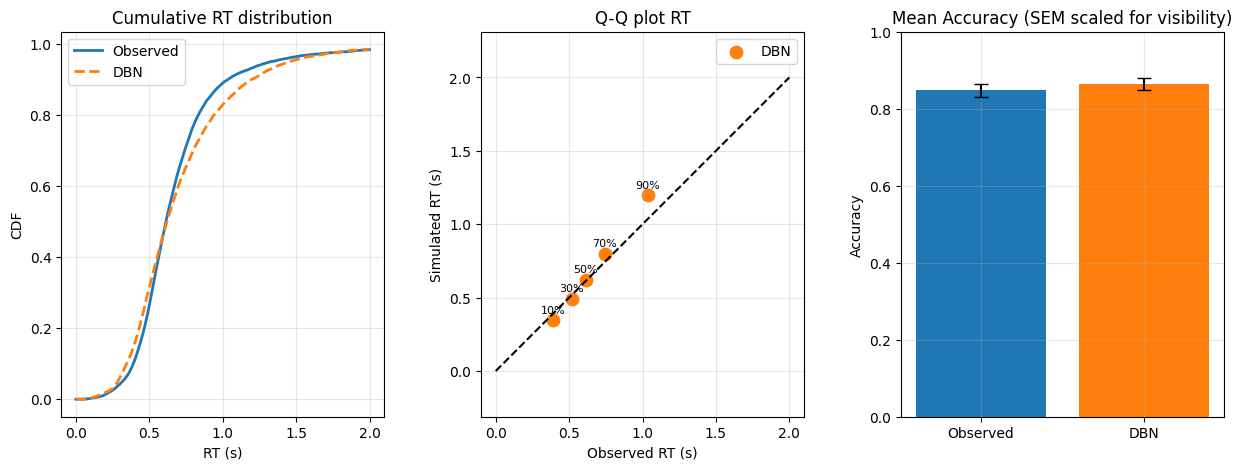

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

all_log_ratio = np.concatenate(all_logratio)

bins = np.linspace(0, 2, 100)
human_cdf = np.array([np.mean(all_human_rt <= b) for b in bins])
sim_cdf = np.array([np.mean(all_sim_rt_dbn <= b) for b in bins])


quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
human_q = np.quantile(all_human_rt, quantiles)
sim_q = np.quantile(all_sim_rt_dbn, quantiles)

acc_human = np.mean(all_human_resp == all_groundtruth)
sem_human = stats.sem(all_human_resp == all_groundtruth)

acc_dbn = np.mean(all_sim_resp_dbn == all_groundtruth)
sem_dbn = stats.sem(all_sim_resp_dbn == all_groundtruth)

# Colori più vivaci
color_obs = "#1f77b4"   # blu
color_dbn = "#ff7f0e"   # arancione

# Figura unica con 3 subplot
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1], wspace=0.3)

# ========================================
# 1. CDF RT
# ========================================
ax0 = fig.add_subplot(gs[0])
ax0.plot(bins, human_cdf, label="Observed", lw=2, color=color_obs)
ax0.plot(bins, sim_cdf, label="DBN", lw=2, linestyle="--", color=color_dbn)
ax0.set_xlabel("RT (s)")
ax0.set_ylabel("CDF")
ax0.set_title("Cumulative RT distribution")
ax0.legend()
ax0.grid(True, alpha=0.3)

# ========================================
# 2. Q-Q plot
# ========================================
ax1 = fig.add_subplot(gs[1])
ax1.scatter(human_q, sim_q, s=80, color=color_dbn, label="DBN")
for i,q in enumerate(quantiles):
    ax1.text(human_q[i], sim_q[i]+0.05, f"{int(q*100)}%", ha="center", fontsize=8)
ax1.plot([0,2], [0,2], "k--")
ax1.set_xlabel("Observed RT (s)")
ax1.set_ylabel("Simulated RT (s)")
ax1.set_title("Q-Q plot RT")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis("equal")

# ========================================
# 3. Mean Accuracy
# ========================================
ax2 = fig.add_subplot(gs[2])
# Forzare barra di errore visibile anche se SEM piccola
error_scaling = 5  # moltiplica SEM per renderla visibile
ax2.bar(["Observed", "DBN"], 
        [acc_human, acc_dbn], 
        yerr=[sem_human*error_scaling, sem_dbn*error_scaling],
        capsize=5, color=[color_obs, color_dbn])
ax2.set_ylim(0,1)
ax2.set_ylabel("Accuracy")
ax2.set_title("Mean Accuracy")
ax2.grid(True, alpha=0.3)

# ========================================
# Salvataggio vettoriale
# ========================================
plt.tight_layout()
plt.savefig("DBN_results.pdf", format="pdf")
plt.show()


In [50]:
all_log_ratio.min()

np.float64(-0.6931471805599453)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats

# ==============================================================
# DATI (già concatenati da tutti i soggetti)
# ==============================================================
# all_human_rt       = tempi osservati
# all_sim_rt_dbn     = tempi simulati dal DBN
# all_human_resp     = risposte osservate (0/1)
# all_sim_resp_dbn   = risposte simulate dal DBN (0/1)
# all_groundtruth    = risposte corrette (0/1)
# all_log_ratio      = log-ratio trial per trial
# ==============================================================
all_log_ratio = np.concatenate(np.log2(np.exp(all_logratio)))




# Definizione dei 4 livelli di log-ratio
ratio_bins = [
    (0.5, 0.6),   # 30 trial
    (0.6, 0.7),   # 60 trial
    (0.7, 0.8),   # 90 trial
    (0.8, 0.9)    # 120 trial
]
labels = ["0.5–0.6", "0.6–0.7", "0.7–0.8", "0.8–0.9"]

# Colori
color_obs = "#1f77b4"   # blu
color_dbn = "#ff7f0e"   # arancione

# Setup figura
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1], wspace=0.3, hspace=0.4)

abs_log_ratio = np.abs(all_log_ratio)


for i, (low, high) in enumerate(ratio_bins):
    # Filtro trial per intervallo
    idx = (abs_log_ratio >= low) & (abs_log_ratio < high)

    human_rt = all_human_rt[idx]
    sim_rt   = all_sim_rt_dbn[idx]
    human_resp = all_human_resp[idx]
    sim_resp   = all_sim_resp_dbn[idx]
    groundtruth = all_groundtruth[idx]

    # =============================
    # CDF RT
    # =============================
    bins = np.linspace(0, 2, 100)
    human_cdf = np.array([np.mean(human_rt <= b) for b in bins])
    sim_cdf   = np.array([np.mean(sim_rt   <= b) for b in bins])

    ax0 = fig.add_subplot(gs[i])
    ax0.plot(bins, human_cdf, label="Observed", lw=2, color=color_obs)
    ax0.plot(bins, sim_cdf, label="DBN", lw=2, linestyle="--", color=color_dbn)
    ax0.set_xlabel("RT (s)")
    ax0.set_ylabel("CDF")
    ax0.set_title(f"RT distribution (log-ratio {labels[i]})")
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # =============================
    # Q-Q plot (solo sui quantili principali)
    # =============================
    quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    human_q = np.quantile(human_rt, quantiles)
    sim_q   = np.quantile(sim_rt, quantiles)

    fig_qq = plt.figure(figsize=(5,5))
    ax1 = fig_qq.add_subplot(111)
    ax1.scatter(human_q, sim_q, s=80, color=color_dbn, label="DBN")
    for j,q in enumerate(quantiles):
        ax1.text(human_q[j], sim_q[j]+0.05, f"{int(q*100)}%", ha="center", fontsize=8)
    ax1.plot([0,2], [0,2], "k--")
    ax1.set_xlabel("Observed RT (s)")
    ax1.set_ylabel("Simulated RT (s)")
    ax1.set_title(f"Q-Q plot (log-ratio {labels[i]})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis("equal")
    fig_qq.tight_layout()
    fig_qq.savefig(f"QQ_logratio_{labels[i]}.pdf", format="pdf")

    # =============================
    # Accuracy
    # =============================
    acc_human = np.mean(human_resp == groundtruth)
    sem_human = stats.sem(human_resp == groundtruth)
    acc_dbn = np.mean(sim_resp == groundtruth)
    sem_dbn = stats.sem(sim_resp == groundtruth)

    # Plot a barre per accuracy
    fig_acc = plt.figure(figsize=(4,5))
    ax2 = fig_acc.add_subplot(111)
    error_scaling = 5
    ax2.bar(["Observed", "DBN"],
            [acc_human, acc_dbn],
            yerr=[sem_human, sem_dbn],
            capsize=5, color=[color_obs, color_dbn])
    ax2.set_ylim(0,1)
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"Accuracy (log-ratio {labels[i]})")
    ax2.grid(True, alpha=0.3)
    fig_acc.tight_layout()
    fig_acc.savefig(f"ACC_logratio_{labels[i]}.pdf", format="pdf")

# ========================================
# Salvataggio delle CDF in un unico file
# ========================================
plt.tight_layout()
plt.savefig("DBN_CDF_by_logratio.pdf", format="pdf")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_params_separate(df_params, param_list=["beta","bias","a","Ter"]):
    """
    Crea un plot separato per ogni parametro DDM, con boxplot dei modelli
    e punti dei singoli soggetti sovrapposti.
    
    df_params: DataFrame con colonne tipo 'beta_log', 'beta_dbn_log', etc. e 'subj'.
    param_list: lista dei parametri da visualizzare
    """
    models = ["log", "dbn_log"]
    sns.set(style="whitegrid")
    
    for param in param_list:
        # Trasformiamo in long format
        df_long = []
        for model in models:
            df_long.append(pd.DataFrame({
                "Model": model,
                "Value": df_params[f"{param}_{model}"],
                "Subject": df_params["subj"]
            }))
        df_long = pd.concat(df_long, ignore_index=True)
        
        plt.figure(figsize=(6,5))
        ax = sns.boxplot(x="Model", y="Value", data=df_long, showfliers=False, palette="Set2")
        sns.stripplot(x="Model", y="Value", data=df_long, jitter=True, color='k', alpha=0.7)
        
        plt.title(f"{param} by Model (Subjects shown)")
        plt.ylabel(param)
        plt.xlabel("Model")
        plt.show()

# Esempio di utilizzo
plot_params_separate(df_params)


In [ ]:
df_params= pd.read_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/DDM/df_params.xlsx")
df_results= pd.read_excel("/home/student/Desktop/Groundeep/conferenza_DBNRT/DDM/df_results.xlsx")
df_params.items

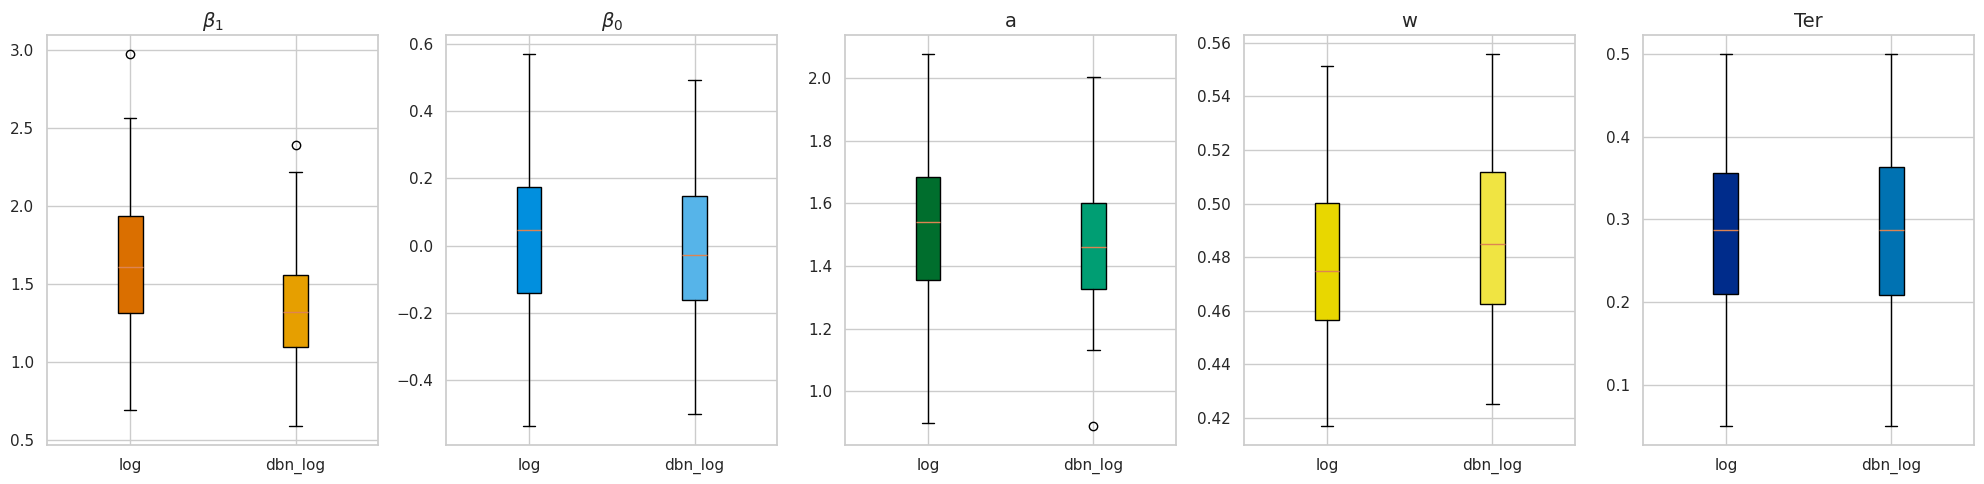

In [111]:
import matplotlib.colors as mcolors
import numpy as np

def lighten_color(color, amount=0.5):
    c = mcolors.to_rgb(color)
    new_c = np.clip((1 - amount) + amount*np.array(c), 0, 1)
    return new_c



def boxplot_ddm_from_df(df):
    parameters = ["beta", "bias", "a", "w_center", "Ter"]
    plot_labels = {
        "bias": r"$\beta_0$",
        "beta": r"$\beta_1$",
        "w_center": "w",
        "a": "a",
        "Ter": "Ter"
    }

    models = ["log", "dbn_log"]  # escludo null

    # Colori di base per DBN
    base_colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
    dbn_colors = base_colors
    log_colors = [lighten_color(c, 1.5) for c in base_colors]  # versione chiara per log

    # Prepara i dati
    simulated_data = {param: [] for param in parameters}
    for param in parameters:
        for model in models:
            colname = f"{param}_{model}"
            simulated_data[param].append(df[colname].values)

    # Plot
    fig, axes = plt.subplots(1, len(parameters), figsize=(20, 5))
    for i, param in enumerate(parameters):
        bp = axes[i].boxplot(simulated_data[param], patch_artist=True, tick_labels=models)
        for j, patch in enumerate(bp['boxes']):
            color = dbn_colors[i] if models[j] == "dbn_log" else log_colors[i]
            patch.set_facecolor(color)
        axes[i].set_title(plot_labels[param], fontsize=14)
    plt.tight_layout()
    plt.show()

# Esempio
boxplot_ddm_from_df(df_params)


/tmp/ipykernel_109278/4169420988.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([simulated_data[i]], labels=["DBN Model"], patch_artist=True)
/tmp/ipykernel_109278/4169420988.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([simulated_data[i]], labels=["DBN Model"], patch_artist=True)
/tmp/ipykernel_109278/4169420988.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([simulated_data[i]], labels=["DBN Model"], patch_artist=True)
/tmp/ipykernel_109278/4169420988.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been ren

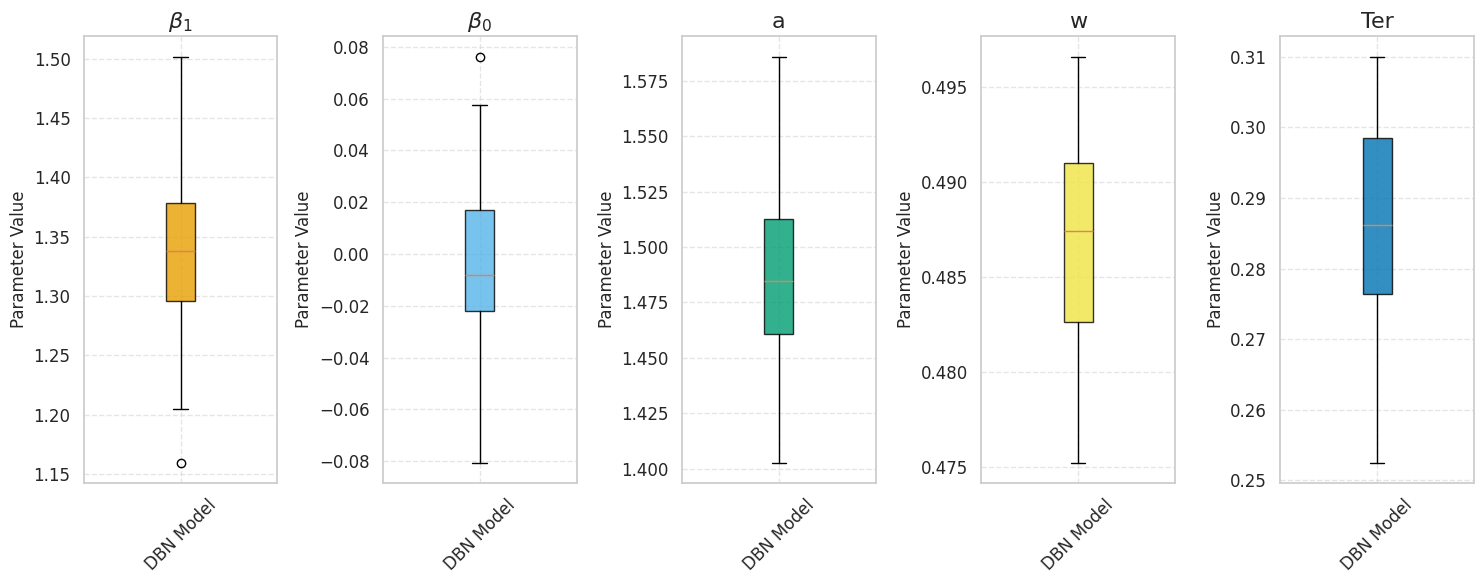

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def boxplot_ddm_params_dbn(param_dict):
    """
    Crea un boxplot colorato dei parametri DDM solo per il modello DBN,
    con nomi dei parametri corretti (lettere greche, pedici) e griglia sullo sfondo.
    
    param_dict: dizionario come fornito, con struttura:
        {'dbn_log': {parametro: [mean, sem], ...}, ...}
    """
    model = 'dbn_log'
    if model not in param_dict:
        raise ValueError(f"{model} non trovato nel dizionario dei parametri.")
    
    # Parametri da mostrare con nomi “presentabili” (greco + pedice)
    param_names_map = {
        'bias': r'$\beta_0$',
        'beta': r'$\beta_1$',
        'w_center': 'w',
        'a': 'a',
        'Ter': 'Ter'
    }
    
    parameters = [p for p in param_dict[model].keys() if p in param_names_map]
    
    # Simuliamo dati per boxplot (media ± sem con distribuzione normale)
    simulated_data = []
    for param in parameters:
        mean, sem = param_dict[model][param]
        values = np.random.normal(loc=mean, scale=sem, size=40)
        simulated_data.append(values)
    
    # Palette color-blind friendly (Okabe & Ito)
    colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    colors = colors[:len(parameters)]
    
    # Plot
    fig, axes = plt.subplots(1, len(parameters), figsize=(3*len(parameters), 6), sharey=False)
    if len(parameters) == 1:
        axes = [axes]
    
    for i, param in enumerate(parameters):
        bp = axes[i].boxplot([simulated_data[i]], labels=["DBN Model"], patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[i])
            patch.set_alpha(0.8)
        
        axes[i].set_title(param_names_map[param], fontsize=16)
        axes[i].set_ylabel("Parameter Value", fontsize=12)
        axes[i].tick_params(axis='x', rotation=45, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.5, zorder=-1)  # griglia dietro
    
    plt.tight_layout()
    plt.show()

# Esempio di chiamata
boxplot_ddm_params_dbn(params_summary)


/tmp/ipykernel_109278/2184786574.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(simulated_data[param], labels=models, patch_artist=True)
/tmp/ipykernel_109278/2184786574.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(simulated_data[param], labels=models, patch_artist=True)
/tmp/ipykernel_109278/2184786574.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(simulated_data[param], labels=models, patch_artist=True)
/tmp/ipykernel_109278/2184786574.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labe

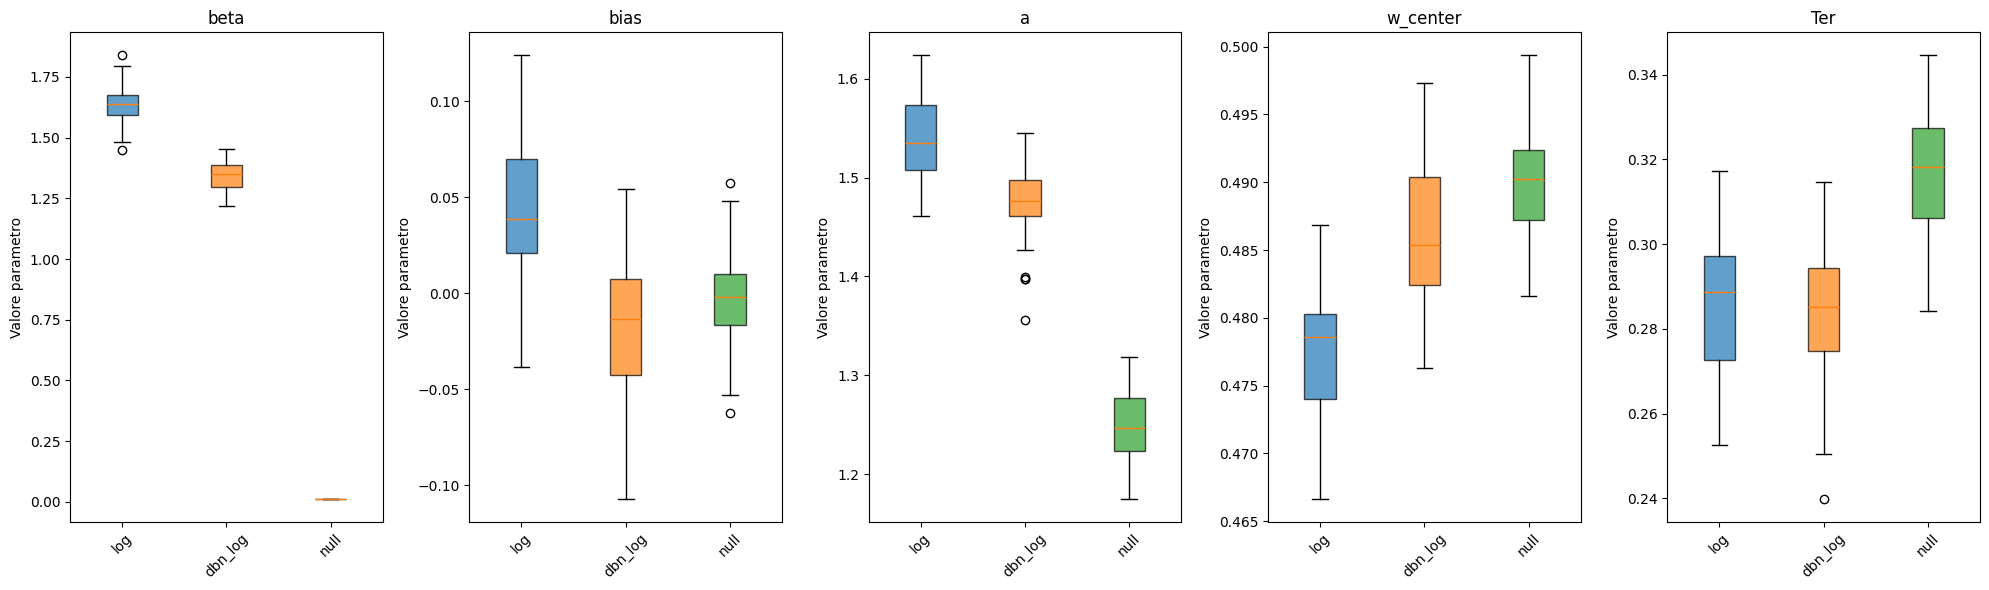

In [69]:
def boxplot_ddm_params(param_dict):
    """
    Crea un boxplot colorato dei parametri DDM per diversi modelli.
    
    param_dict: dizionario nested come quello fornito
        {modello: {parametro: [mean, sem]}}
    """
    models = list(param_dict.keys())
    parameters = list(next(iter(param_dict.values())).keys())
    
    # Simuliamo dati per boxplot (media ± sem con distribuzione normale)
    simulated_data = {param: [] for param in parameters}
    for param in parameters:
        for model in models:
            mean, sem = param_dict[model][param]
            # Generiamo 40 valori distribuiti intorno alla media usando SEM
            values = np.random.normal(loc=mean, scale=sem, size=40)
            simulated_data[param].append(values)
    
    # Palette di colori
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', "#e71717", '#9467bd']  # puoi cambiare o estendere
    colors = colors[:len(models)]
    
    # Plot
    fig, axes = plt.subplots(1, len(parameters), figsize=(4*len(parameters), 6), sharey=False)
    if len(parameters) == 1:
        axes = [axes]
    
    for i, param in enumerate(parameters):
        bp = axes[i].boxplot(simulated_data[param], labels=models, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[i].set_title(param)
        axes[i].set_ylabel("Valore parametro")
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
boxplot_ddm_params(params_summary)

In [83]:
print(df_results)
print("Expected frequencies:", bms_results["expected_frequencies"])
print("Exceedance probs:", bms_results["exceedance_probs"])
print("Params:", params_summary
      )

    subj      ll_log     AIC_log     BIC_log  ll_dbn_log  AIC_dbn_log  \
0      1  -61.627523  133.255045  151.773957  -73.599859   157.199718   
1      2  -25.619233   61.238465   79.757378  -65.854897   141.709794   
2      3   -5.809620   21.619240   40.138153  -14.831964    39.663929   
3      4  -88.636151  187.272303  205.791215 -128.768776   267.537551   
4      5  -55.257443  120.514886  139.033798  -71.999663   153.999326   
5      6 -163.752370  337.504740  356.023653 -141.920970   293.841940   
6      7 -132.305210  274.610420  293.129332 -164.544612   339.089225   
7      8 -313.111850  636.223701  654.742613 -321.503281   653.006563   
8      9 -226.383906  462.767811  481.286723 -229.611179   469.222357   
9     10   26.119156  -42.238313  -23.719401    6.650762    -3.301524   
10    11  -58.664726  127.329452  145.848365  -70.348321   150.696641   
11    12   -3.891591   17.783181   36.302094  -40.530984    91.061969   
12    13 -240.198221  490.396441  508.915353 -282.0

In [87]:
import numpy as np
from scipy import stats

# Estrarre i dati dai DataFrame o array
ll_log = np.array(df_results['ll_log'])
ll_dbn = np.array(df_results['ll_dbn_log'])
AIC_log = np.array(df_results['AIC_log'])
AIC_dbn = np.array(df_results['AIC_dbn_log'])
BIC_log = np.array(df_results['BIC_log'])
BIC_dbn = np.array(df_results['BIC_dbn_log'])

# Funzione media ± SEM
def mean_sem(x):
    return np.mean(x), stats.sem(x)

# Calcolo
metrics = {
    'Log-likelihood': (ll_log, ll_dbn),
    'AIC': (AIC_log, AIC_dbn),
    'BIC': (BIC_log, BIC_dbn)
}

results_summary = {}
for metric, (log_vals, dbn_vals) in metrics.items():
    results_summary[metric] = {
        'Log model': mean_sem(log_vals),
        'DBN model': mean_sem(dbn_vals)
    }

results_summary

{'Log-likelihood': {'Log model': (np.float64(-77.68341861108335),
   np.float64(17.609468743744447)),
  'DBN model': (np.float64(-95.54175078436556),
   np.float64(17.36897747100734))},
 'AIC': {'Log model': (np.float64(165.3668372221667),
   np.float64(35.218937487488894)),
  'DBN model': (np.float64(201.08350156873112),
   np.float64(34.73795494201468))},
 'BIC': {'Log model': (np.float64(183.88574959544775),
   np.float64(35.218937487488894)),
  'DBN model': (np.float64(219.6024139420121), np.float64(34.73795494201468))}}

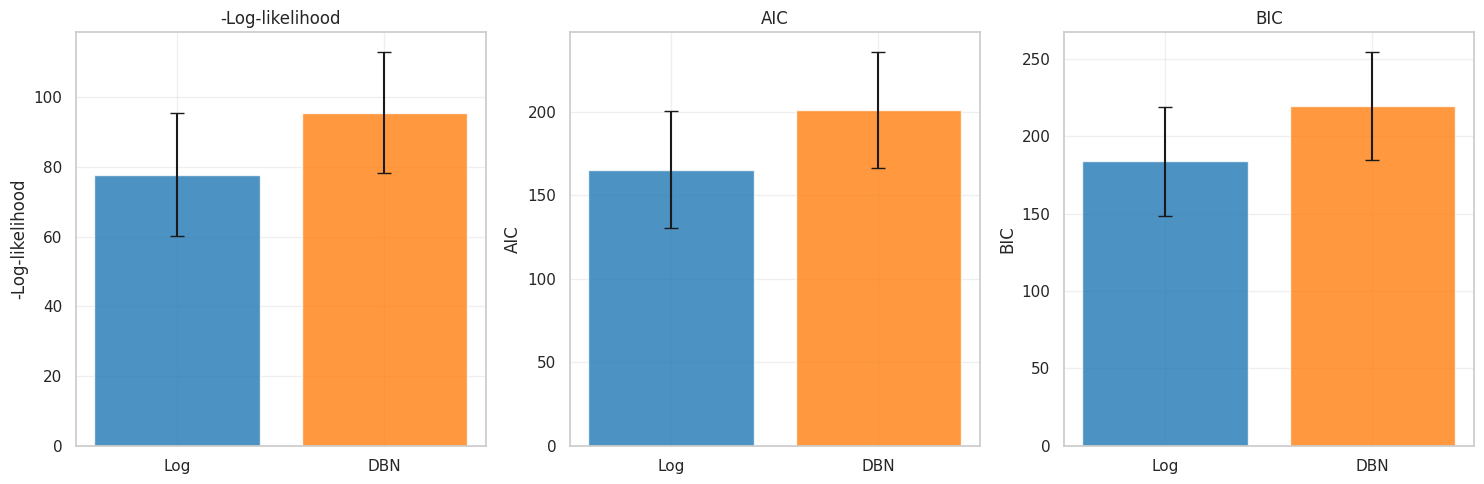

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Raccogliamo i valori in array
ll_log = np.array(df_results['ll_log'])
ll_dbn = np.array(df_results['ll_dbn_log'])
AIC_log = np.array(df_results['AIC_log'])
AIC_dbn = np.array(df_results['AIC_dbn_log'])
BIC_log = np.array(df_results['BIC_log'])
BIC_dbn = np.array(df_results['BIC_dbn_log'])

# Funzione per media e SEM
def mean_sem(x):
    return np.mean(x), stats.sem(x)

metrics = {
    '-Log-likelihood': (-ll_log, -ll_dbn),  # trasformiamo in positivo per plottare
    'AIC': (AIC_log, AIC_dbn),
    'BIC': (BIC_log, BIC_dbn)
}

models = ['Log', 'DBN']
colors = ['#1f77b4', '#ff7f0e']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, (metric_name, (m1, m2)) in enumerate(metrics.items()):
    means = [np.mean(m1), np.mean(m2)]
    sems  = [stats.sem(m1), stats.sem(m2)]
    
    axes[i].bar(models, means, yerr=sems, color=colors, capsize=5, alpha=0.8)
    axes[i].set_title(metric_name)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylabel(metric_name)
    # Etichetta chiara per log-likelihood
    if metric_name == 'Negative Log-likelihood':
        axes[i].set_ylabel('Positive -LL (higher = better fit)')

plt.tight_layout()
plt.show()



Simulated [RT, resp]:
 [[0.473 1.   ]
 [0.288 1.   ]
 [0.557 0.   ]
 [0.308 0.   ]
 [0.395 1.   ]
 [0.781 1.   ]
 [0.329 1.   ]
 [0.335 1.   ]
 [0.459 0.   ]
 [0.237 1.   ]
 [0.276 0.   ]
 [0.293 1.   ]
 [0.405 0.   ]
 [0.304 1.   ]
 [0.336 0.   ]
 [0.292 0.   ]
 [1.481 0.   ]
 [1.126 1.   ]
 [0.374 0.   ]
 [0.312 0.   ]
 [0.559 1.   ]
 [0.31  1.   ]
 [0.616 1.   ]
 [0.305 0.   ]
 [0.453 0.   ]
 [0.265 1.   ]
 [0.422 1.   ]
 [0.557 1.   ]
 [0.481 0.   ]
 [0.634 1.   ]
 [0.301 0.   ]
 [0.268 0.   ]
 [0.698 0.   ]
 [0.298 0.   ]
 [0.892 0.   ]
 [0.422 0.   ]
 [0.459 1.   ]
 [0.333 1.   ]
 [0.335 1.   ]
 [0.392 1.   ]
 [0.347 1.   ]
 [0.337 0.   ]
 [0.528 1.   ]
 [0.9   0.   ]
 [0.3   0.   ]
 [0.697 0.   ]
 [0.401 0.   ]
 [0.642 0.   ]
 [0.503 0.   ]
 [0.308 1.   ]
 [0.457 1.   ]
 [0.343 1.   ]
 [0.873 0.   ]
 [0.335 0.   ]
 [0.354 1.   ]
 [0.788 1.   ]
 [0.293 0.   ]
 [0.356 1.   ]
 [0.667 0.   ]
 [0.292 1.   ]
 [0.288 1.   ]
 [0.295 1.   ]
 [0.516 1.   ]
 [0.286 0.   ]
 [0.301 0.   ]
 [

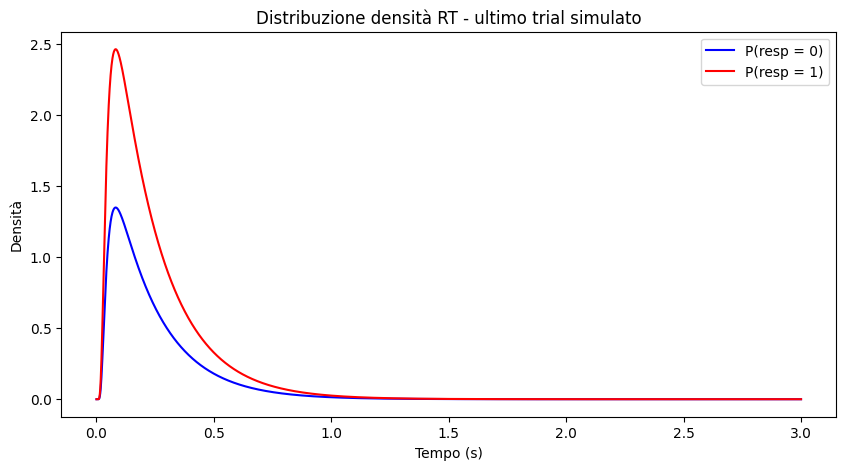

In [16]:
import numpy as np
import matplotlib.pyplot as plt
numerosity1 = num_1
numerosity2 = num_2
log_ratio = np.log(numerosity1 / numerosity2)  # Calcolo del log-ratio
# === Input ===
# log_ratio: shape (n_trials, embedding_dim), es. calcolato da log(emb1 / emb2)
# groundtruth_binary: array di 0 o 1 (es. 1 se emb1 dovrebbe vincere, 0 se emb2)
# === Parametri DDM ===
beta = 3            # scaling del drift
a =  1              # separazione barriere
w_center = 0.5              # punto di partenza base
b_w = 0.7                   # influenza del bias percettivo su w
Ter = 0.2                 # tempo non decisionale
t_vals = np.arange(0.001, 3, 0.001)

# === Calcolo muhat (log-ratio medio per trial) ===
muhat =  np.array(log_ratio)# shape: (n_trials,)
u = groundtruth_binary.astype(float)      # forza tipo float

# === Calcolo dei parametri trial-wise ===
v = beta * muhat                          # drift rate: proporzionale alla log-ratio
w = w_center        # punto di partenza modulato
w = np.clip(w, 0.01, 0.99)                # evita estremi 0 o 1
a_vec = np.full_like(v, fill_value=a)    # barriera fissa

# === Simulazione ===
rt = np.zeros(len(u))
resp = np.zeros(len(u))

for n in range(len(u)):
    P1 = utl_wfpt(t_vals, -v[n], a_vec[n], 1 - w)
    P2 = utl_wfpt(t_vals,  v[n], a_vec[n], w)
    
    P = np.concatenate([P2[::-1], P1])
    time_values = np.concatenate([-t_vals[::-1], t_vals])
    
    P_sum = np.sum(P)
    if P_sum == 0 or np.isnan(P_sum):
        rt[n] = np.nan
        resp[n] = np.nan
        continue

    P /= P_sum
    selected_time = np.random.choice(time_values, p=P)
    
    rt[n] = abs(selected_time)
    resp[n] = 1 if selected_time > 0 else 0

# === Aggiusta per il non-decision time ===
rt += Ter
rt = rt

y = np.column_stack((rt, resp))

# === Output ===
print("Simulated [RT, resp]:\n", y)

# === Plot distribuzioni dell'ultimo trial simulato (esempio) ===
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_vals, P1, label='P(resp = 0)', color='blue')
ax.plot(t_vals, P2, label='P(resp = 1)', color='red')
ax.set_title("Distribuzione densità RT - ultimo trial simulato")
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Densità")
ax.legend()
plt.show()
